### Enabling new scholarly research scenarios using web APIs: the goetgevonden case

This notebook demonstrates how to use the Goetgevonden API. We begin with easier, more exploratory cells, and then move towards more complex use cases that are not possible with the Goetgevonden app (https://app.goetgevonden.nl).


In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from annorepo.client import AnnoRepoClient

This cell connects to the Goetgevonden API and lists all the different endpoints in it and what their use is. BRINTA (BRoccoli INdex for Texts and Annotations) is the name for the ElasticSearch instance in the API. At the end, we retrieve the about-page that displays, amongst others, the version of the app and when it was started.


In [2]:
# Base URL of Goetgevonden API
api_url = "https://api.goetgevonden.nl"
# The Goetgevonden project is also known as "Republic"
project = "republic"
goetgevonden_base = "/projects/" + project
goetgevonden_brinta_base = "/brinta/" + project

# About endpoint
about = "/about"

# Swagger endpoint
swagger = "/swagger"

# Search endpoint
search_endpoint = goetgevonden_base + "/search"

# Views endpoint (unused for Goetgevonden). A view is a per project configurable view on the text stream, e.g., the original text and a translation of that text. This endpoint lists all views configured for the project and the data on which those views are based.
views = goetgevonden_base + "/views"

# Endpoint to get all unique annotation types in the Goetgevonden dataset
unique_anno_types_endpoint = goetgevonden_base

# Endpoint to get all ElasticSearch indices, their keys, and their field types
indices_endpoint = goetgevonden_brinta_base + "/indices"

response = requests.get(api_url + about)
data = response.json()
print(json.dumps(data, indent=2))

{
  "appName": "Broccoli",
  "version": "0.40.2",
  "startedAt": "2025-05-02T07:41:33.085632046Z",
  "baseURI": "https://api.goetgevonden.nl",
  "hucLogLevel": "DEBUG"
}


Let us begin with fetching the indices endpoint to see what the name of the ElasticSearch index is, what metadata is indexed, and what their field types are.

The key for full-text search is not displayed in this endpoint. If you want to do a full-text search in the API, you have to use key `text`, as will be demonstrated in the next cell.


In [3]:
response = requests.get(api_url + indices_endpoint)
data = response.json()
print(json.dumps(data, indent=2))

{
  "republic-2024.11.30": {
    "textType": "keyword",
    "resolutionType": "keyword",
    "propositionType": "keyword",
    "delegateName": "keyword",
    "personName": "keyword",
    "roleName": "keyword",
    "roleCategories": "keyword",
    "locationName": "keyword",
    "locationCategories": "keyword",
    "organisationName": "keyword",
    "organisationCategories": "keyword",
    "commissionName": "keyword",
    "commissionCategories": "keyword",
    "sessionWeekday": "keyword",
    "delegateId": "keyword",
    "personId": "keyword",
    "roleId": "keyword",
    "locationId": "keyword",
    "organisationId": "keyword",
    "commissionId": "keyword",
    "bodyType": "keyword",
    "sessionDate": "date",
    "sessionDay": "byte",
    "sessionMonth": "byte",
    "sessionYear": "short"
  }
}


We can also fetch the unique annotation types endpoint to see which types of Web Annotations are available in the Goetgevonden dataset.

**NB. Only `Resolution` Web Annotations are indexed. If you want to search for other annotation types, you will have to query AnnoRepo directly, as will be demonstrated in use case 2.**


In [4]:
response = requests.get(api_url + unique_anno_types_endpoint)
data = response.json()
print(json.dumps(data, indent=2))

[
  "DateOccurrence",
  "Entity",
  "Page",
  "Paragraph",
  "Resolution",
  "Session",
  "Volume"
]


Now that we know what metadata is indexed, we can begin with a very simple query: search for the occurrences of the word `paard` (= horse) in resolutions of proposition type `memorie`.


In [5]:
simple_query = {"text": "paard", "terms": {"propositionType": ["memorie"]}}

response = requests.post(api_url + search_endpoint, json=simple_query)
data = response.json()
print(json.dumps(data, indent=2, ensure_ascii=False))

{
  "total": {
    "value": 14,
    "relation": "eq"
  },
  "results": [
    {
      "_id": "urn:republic:inv-3805-date-1750-02-25-session-54-resolution-2",
      "_hits": {
        "text": [
          "dat een Pasport in behoorlijcke forma sal werden gedepecheert, om dertigh Koppel Jaghthonden en een <em>Paard</em>"
        ]
      },
      "textType": "printed",
      "resolutionType": "ordinaris",
      "propositionType": "memorie",
      "sessionWeekday": "woensdag",
      "bodyType": "Resolution",
      "sessionDate": "1750-02-25",
      "sessionDay": 25,
      "sessionMonth": 2,
      "sessionYear": 1750
    },
    {
      "_id": "urn:republic:inv-3798-date-1743-10-30-session-292-resolution-6",
      "_hits": {
        "text": [
          "gedepescheert, om neegen Koetspaarden, verselt van ses Domesticquen, om deselve te geleyden, elck op een kleyn <em>Paard</em>"
        ]
      },
      "textType": "printed",
      "resolutionType": "ordinaris",
      "propositionType": "memori

After this (very) short introduction, we can begin with the more complex use cases. These use cases were created by Marijn Koolen and the Goetgevonden team during the course of the project.


# Use case 1

Did the numerical relation between secret and ordinary resolutions change from 1671 to 1720? (to also include the 'Rampjaar' 1672)


First, we query the API for resolutions between 1671 and 1720 that are of type `secreet`. We also ask for the aggregations of `sessionYear` because we can use that for the number of secret resolutions per year.


In [6]:
secret_query = {
    "terms": {"resolutionType": ["secreet"]},
    "date": {"name": "sessionDate", "from": "1671-01-01", "to": "1720-12-31"},
    "aggs": {"sessionYear": {"size": 250}},
}

result = requests.post(api_url + search_endpoint, json=secret_query)
data = result.json()

number_of_secret_resolutions_per_year = []

for years in data["aggs"]["sessionYear"]:
    number_of_secret_resolutions_per_year.append(
        {"year": int(years), "count": int(data["aggs"]["sessionYear"][years])}
    )

number_of_secret_resolutions_per_year = sorted(
    number_of_secret_resolutions_per_year, key=lambda x: x["year"]
)

print(json.dumps(number_of_secret_resolutions_per_year, indent=2))

[
  {
    "year": 1671,
    "count": 159
  },
  {
    "year": 1672,
    "count": 603
  },
  {
    "year": 1673,
    "count": 525
  },
  {
    "year": 1674,
    "count": 539
  },
  {
    "year": 1675,
    "count": 574
  },
  {
    "year": 1676,
    "count": 667
  },
  {
    "year": 1677,
    "count": 573
  },
  {
    "year": 1678,
    "count": 525
  },
  {
    "year": 1679,
    "count": 194
  },
  {
    "year": 1680,
    "count": 248
  },
  {
    "year": 1681,
    "count": 281
  },
  {
    "year": 1682,
    "count": 403
  },
  {
    "year": 1683,
    "count": 446
  },
  {
    "year": 1684,
    "count": 323
  },
  {
    "year": 1685,
    "count": 240
  },
  {
    "year": 1686,
    "count": 231
  },
  {
    "year": 1687,
    "count": 290
  },
  {
    "year": 1688,
    "count": 461
  },
  {
    "year": 1689,
    "count": 818
  },
  {
    "year": 1690,
    "count": 689
  },
  {
    "year": 1691,
    "count": 623
  },
  {
    "year": 1692,
    "count": 503
  },
  {
    "year": 1693,
    "cou

We do the same for resolutions of type `ordinaris`.


In [7]:
ordinary_query = {
    "terms": {"resolutionType": ["ordinaris"]},
    "date": {"name": "sessionDate", "from": "1671-01-01", "to": "1720-12-31"},
    "aggs": {"sessionYear": {"size": 250}},
}

result = requests.post(api_url + search_endpoint, json=ordinary_query)
data = result.json()

number_of_ordinary_resolutions_per_year = []

for years in data["aggs"]["sessionYear"]:
    number_of_ordinary_resolutions_per_year.append(
        {"year": int(years), "count": int(data["aggs"]["sessionYear"][years])}
    )

number_of_ordinary_resolutions_per_year = sorted(
    number_of_ordinary_resolutions_per_year, key=lambda x: x["year"]
)

print(json.dumps(number_of_ordinary_resolutions_per_year, indent=2))

[
  {
    "year": 1671,
    "count": 3335
  },
  {
    "year": 1672,
    "count": 3906
  },
  {
    "year": 1673,
    "count": 3373
  },
  {
    "year": 1674,
    "count": 3300
  },
  {
    "year": 1675,
    "count": 3178
  },
  {
    "year": 1676,
    "count": 3313
  },
  {
    "year": 1677,
    "count": 3313
  },
  {
    "year": 1678,
    "count": 3128
  },
  {
    "year": 1679,
    "count": 2775
  },
  {
    "year": 1680,
    "count": 2524
  },
  {
    "year": 1681,
    "count": 2648
  },
  {
    "year": 1682,
    "count": 2860
  },
  {
    "year": 1683,
    "count": 2934
  },
  {
    "year": 1684,
    "count": 2753
  },
  {
    "year": 1685,
    "count": 2859
  },
  {
    "year": 1686,
    "count": 2893
  },
  {
    "year": 1687,
    "count": 2727
  },
  {
    "year": 1688,
    "count": 2976
  },
  {
    "year": 1689,
    "count": 4166
  },
  {
    "year": 1690,
    "count": 4353
  },
  {
    "year": 1691,
    "count": 3986
  },
  {
    "year": 1692,
    "count": 4155
  },
  {
    

Here, the data is added to a Pandas DataFrame and then plotted on a bar chart.


In [8]:
df = pd.DataFrame(
    {
        "secret": number_of_secret_resolutions_per_year,
        "ordinary": number_of_ordinary_resolutions_per_year,
    }
)

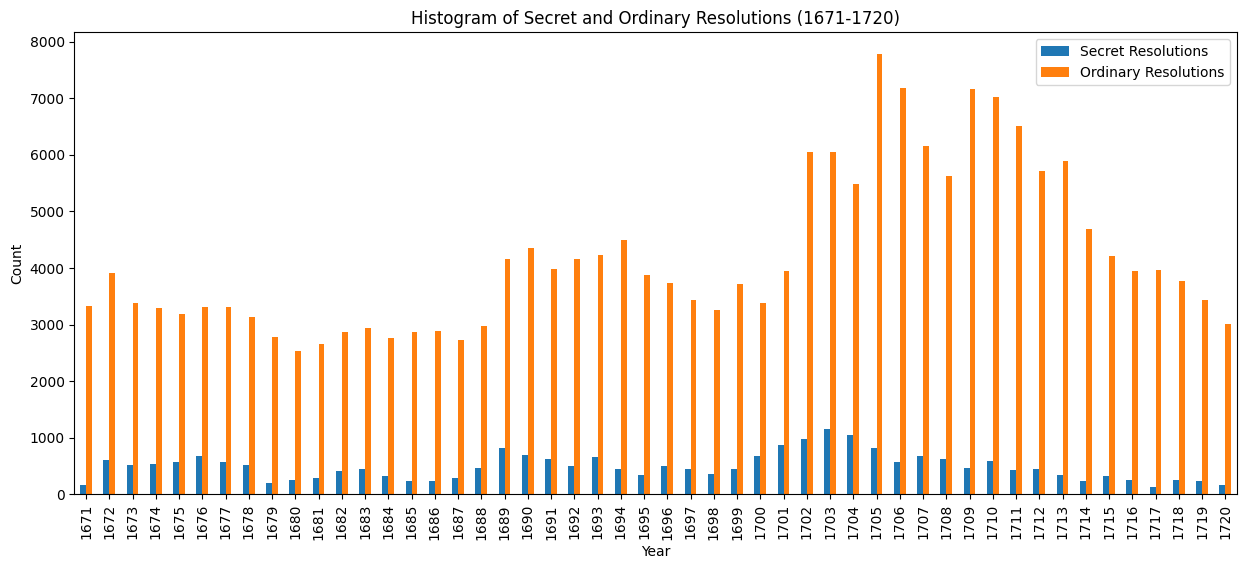

In [9]:
df["secret_count"] = df["secret"].apply(lambda x: x["count"])
df["ordinary_count"] = df["ordinary"].apply(lambda x: x["count"])
df["year"] = df["secret"].apply(lambda x: x["year"])
df.set_index("year", inplace=True)

df[["secret_count", "ordinary_count"]].plot(kind="bar", figsize=(15, 6))
plt.title("Histogram of Secret and Ordinary Resolutions (1671-1720)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Secret Resolutions", "Ordinary Resolutions"])
plt.show()

This is not a very usable visualisation of the data, so let's plot the ratio of secret to ordinary resolutions between 1671–1720.


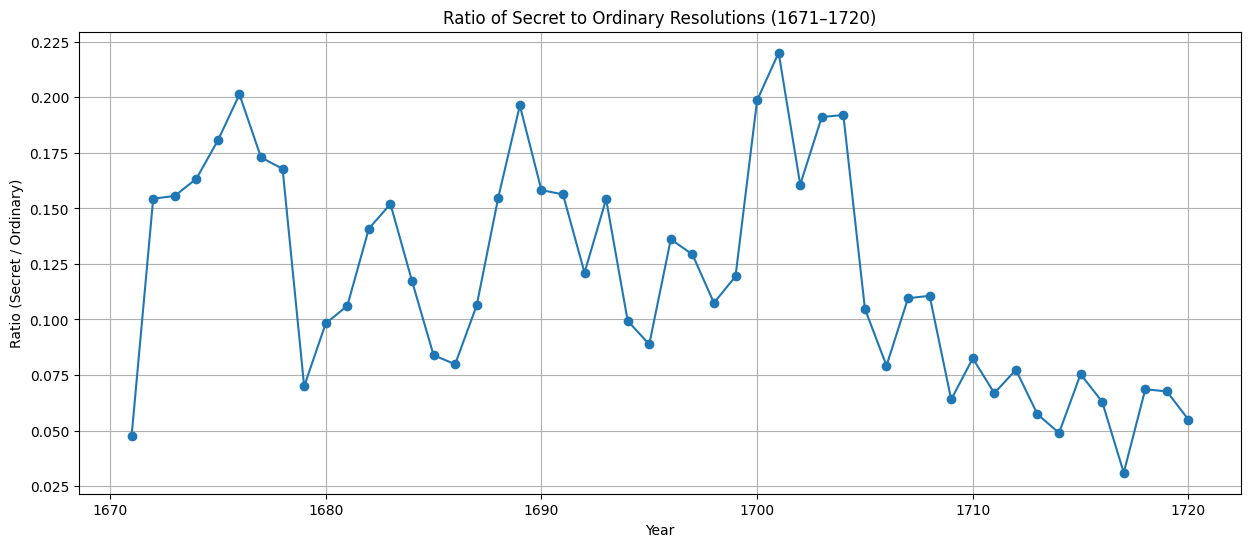

count    50.000000
mean      0.118888
std       0.048799
min       0.031014
25%       0.077822
50%       0.110118
75%       0.156135
max       0.220107
Name: ratio, dtype: float64


In [10]:
df["ratio"] = df["secret_count"] / df["ordinary_count"]

df["ratio"].plot(kind="line", figsize=(15, 6), marker="o")
plt.title("Ratio of Secret to Ordinary Resolutions (1671–1720)")
plt.xlabel("Year")
plt.ylabel("Ratio (Secret / Ordinary)")
plt.grid(True)
plt.show()

print(df["ratio"].describe())

# Use case 2

Which provinces and which delegates attended the sessions of the resolutions most frequently at the time of Frederik Henry (stadholder between 1625 and 1647)?


The data for which provinces and which delegates attended the resolutions is available in the Web Annotation of type `Session`. Every session (that is detected by the Goetgevonden team) of the States General has its own Web Annotation. Often, multiple resolutions were taken in one session.

This use case can be tackled in two ways:

1. Use ElasticSearch via the broker to get all resolutions between 1625–1647, query the broker to get all `Session` annotations that overlap with the `Resolution` annotation, and then extract the information about the provinces and delegates.
2. Query AnnoRepo directly to get all `Session` annotations between 1625–1647, after which you can extract the information about the provinces and delegates.

In the following cells, we will query AnnoRepo directly. The ElasticSearch route is needlessly complex.


First, we have to define the URL of the Goetgevonden AnnoRepo instance (https://annorepo.goetgevonden.nl). To get an overview of all the active AnnoRepo containers for this project, we can use the containers endpoint. We will use container `republic-2024.11.30` during this example, because this is the container that is active in the web application (https://app.goetgevonden.nl) and indexed in ElasticSearch.


In [11]:
annorepo_url = "https://annorepo.goetgevonden.nl"
ar_container_endpoint = "/my/containers"

response = requests.get(annorepo_url + ar_container_endpoint)
data = response.json()

print(json.dumps(data, indent=2))

{
  "GUEST": [
    "republic-2024.11.18",
    "republic-2024.11.30",
    "republic-2025-04-29",
    "republic-2025-05-01"
  ]
}


With this information, we can connect to the AnnoRepo instance with the AnnoRepo Python client and create a search query. For more information on the AnnoRepo API, see: https://github.com/knaw-huc/annorepo/blob/main/docs/api-usage.md.

The `create_search` function of the AnnoRepo Python client returns a `SearchInfo` object. We only need the `id` to read the search results of the query in the next cell.

**NB. The search ID of an AnnoRepo query is only valid for 1 hour. This timer is reset if you visit the result within 1 hour. Also, due to optimalisations in AnnoRepo by using the MongoDB Cursor, AnnoRepo does not signal when the search query is done. Our query is small, meaning it's completed quickly. Larger queries might take up to a few minutes to complete.**


In [12]:
ar_client = AnnoRepoClient(annorepo_url)
container_name = "republic-2024.11.30"

ar_query = {
    "body.type": "Session",
    "body.metadata.sessionYear": {":>=": 1625, ":<=": 1647},
}

search_info = ar_client.create_search(container_name, ar_query)
print(search_info.id)  # The Search ID is only valid for 1 hour

42a0464d-b6fd-4ab0-b6c9-68e7f4634b03


We can use the `read_search_result_annotations` function of the AnnoRepo client to get all search results. This function returns an `Iterator`, so in this cell we iterate of the results of this function and append this to `annos`.


In [13]:
annos = []

for web_annotation in ar_client.read_search_result_annotations(
    container_name, search_info.id
):
    annos.append(web_annotation)

Let us investigate how the delegates are represented in the Web Annotations. The delegates are given in `body.metadata.delegates`, so let's print that (you can adjust the `print` to see different parts of the Web Annotation, if necessary). For this use case, we are interested in the provinces and delegates that attended the sessions. In the output, we can see we will need `province` and `name` to answer the question.


In [30]:
print(
    json.dumps(annos[0]["body"]["metadata"]["delegates"], indent=2, ensure_ascii=False)
)

[
  {
    "delegateID": "G02234",
    "name": "A. de Rode",
    "province": "Utrecht",
    "president": false,
    "detailsUrl": "https://entiteiten.goetgevonden.nl/gedeputeerde/G02234"
  },
  {
    "delegateID": "G02325",
    "name": "A. van Randwijck",
    "province": "Gelderland",
    "president": false,
    "detailsUrl": "https://entiteiten.goetgevonden.nl/gedeputeerde/G02325"
  },
  {
    "delegateID": "G02217",
    "name": "Bouchorst, Nicolaes van den",
    "province": "Holland",
    "president": false,
    "detailsUrl": "https://entiteiten.goetgevonden.nl/gedeputeerde/G02217"
  },
  {
    "delegateID": "G02274",
    "name": "Broersema, Pabe",
    "province": "Groningen",
    "president": false,
    "detailsUrl": "https://entiteiten.goetgevonden.nl/gedeputeerde/G02274"
  },
  {
    "delegateID": "G02201",
    "name": "Brouchoven, Jacob van",
    "province": "Holland",
    "president": false,
    "detailsUrl": "https://entiteiten.goetgevonden.nl/gedeputeerde/G02201"
  },
  {
    "

We can use the built-in `Counter` object to count the provinces and delegates in the data.


In [44]:
province_counter = Counter()
delegate_counter = Counter()

for anno in annos:
    for delegate in anno["body"]["metadata"]["delegates"]:
        province_counter[delegate["province"]] += 1
        delegate_counter[delegate["name"]] += 1

In [35]:
province_df = pd.DataFrame.from_records(
    province_counter.most_common(), columns=["province", "count"]
)
province_df

,province,count
0,Holland,16882
1,Gelderland,9473
2,Friesland,7515
3,Groningen,6954
4,,6495
5,Zeeland,5142
6,Overijssel,5096
7,Utrecht,2976


In [36]:
delegate_df = pd.DataFrame.from_records(
    delegate_counter.most_common(), columns=["delegate", "count"]
)
delegate_df

,delegate,count
0,Veltdriel,4399
1,Backer,3069
2,Cats,2552
3,Aldringa,2204
4,Clant,2175
...,...,...
264,Schaep,1
265,Buttercoper,1
266,Dirck Sijmonsz.,1
267,"Camerling, Nicolaes",1


Finally, we have reached the point where we can plot the data. We begin with plotting the province data. If the province the delegate represented is unknown, it's represented as an empty string in the data. In this cell, we map the empty string to `"Unknown"`.


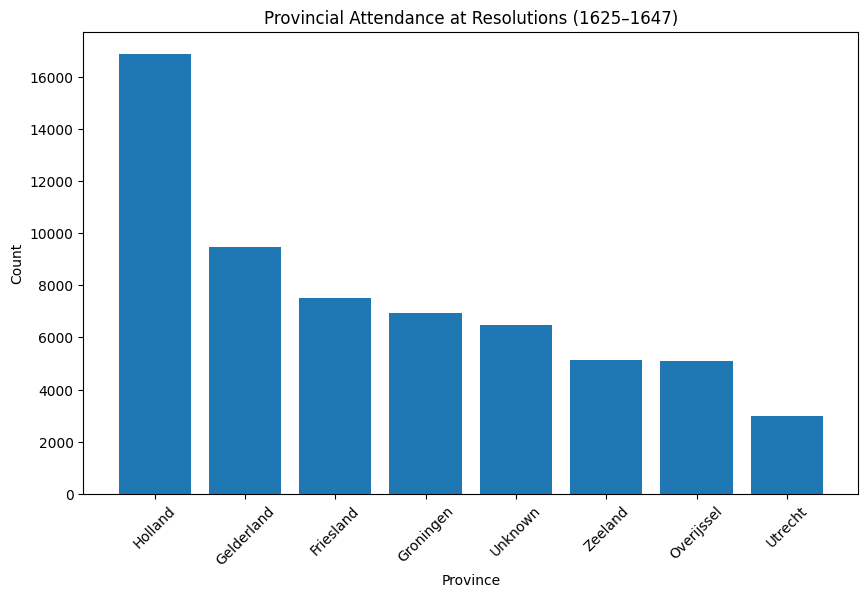

In [45]:
province_sorted = dict(
    sorted(
        ((key if key else "Unknown", value) for key, value in province_counter.items()),
        key=lambda item: item[1],
        reverse=True,
    )
)

plt.figure(figsize=(10, 6))
plt.bar(list(province_sorted.keys()), list(province_sorted.values()))
plt.title("Provincial Attendance at Resolutions (1625–1647)")
plt.xlabel("Province")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

There are too many delegates to properly show in a bar charts, so we only display the top 20. You can adjust the `top_n` variable to display more or less delegates in the chart.


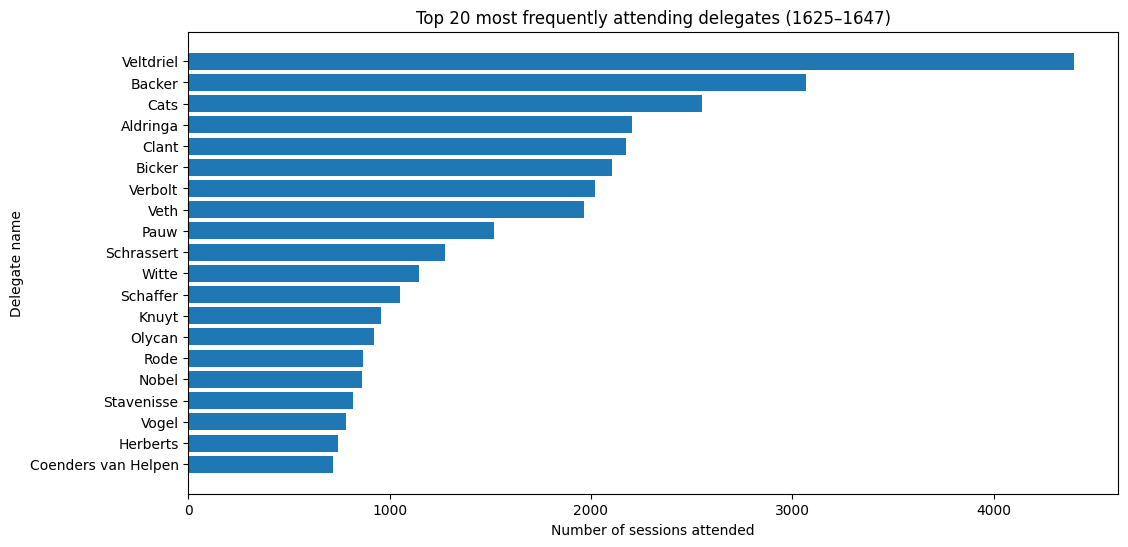

In [18]:
top_n = 20
top_delegates = delegate_counter.most_common(top_n)

names, counts = zip(*top_delegates)

plt.figure(figsize=(12, 6))
plt.barh(names[::-1], counts[::-1])
plt.xlabel("Number of sessions attended")
plt.ylabel("Delegate name")
plt.title(f"Top {top_n} most frequently attending delegates (1625–1647)")
plt.show()

# Use case 3

Did the average length of resolution text change from the handwritten to the printed resolutions?

- Query the API for resolutions from before printing (e.g. 1690–1703) and after printing (e.g. 1703–1715)
- Get token count of resolution from the search results. It can be found in `textTokenCount`.

This use case is not entirely finished. Only the query for the handwritten resolutions is complete.


The search results are fetched per year to circumvent the `max_result_window` limit of 10.000 hits in ElasticSearch (https://www.elastic.co/docs/reference/elasticsearch/index-settings/index-modules#index-max-result-window).


In [ ]:
broccoli_dev_url = "https://broccoli.tt.di.huc.knaw.nl"  # resolution text length is only available in dev Broccoli for the moment

current_year = 1690
final_year = 1702

query_handwritten = {
    "date": {
        "name": "sessionDate",
        "from": f"{current_year}-01-01",
        "to": f"{current_year}-12-31",
    },
}

params = {"from": 0, "size": 100, "sortBy": "sessionDate", "sortOrder": "asc"}


def get_results_per_page(query_params, query_body):
    page_result = requests.post(
        broccoli_dev_url + search_endpoint, json=query_body, params=query_params
    )

    return page_result.json()


token_counts = {}

for year in range(current_year, final_year + 1):
    print(f"Fetching data for year {year}")
    all_results_fetched = False
    start_from = 0

    query_handwritten["date"]["from"] = f"{year}-01-01"
    query_handwritten["date"]["to"] = f"{year}-12-31"

    while not all_results_fetched:
        result = get_results_per_page(params, query_handwritten)
        if result is None:
            break

        print(f"Fetching from: {start_from}")

        if "results" in result:
            for res in result["results"]:
                session_year = res["sessionYear"]
                token_count = res["textTokenCount"]
                if session_year not in token_counts:
                    token_counts[session_year] = []
                token_counts[session_year].append(token_count)
            start_from += params["size"]

            if start_from >= result["total"]["value"]:
                all_results_fetched = True
                print(f"All results fetched for year {year}")
        else:
            print(f"No results fetched for year {year}")
            all_results_fetched = True

print("Fetching complete")

Fetching data for year 1690
Fetching from: 0
Fetching from: 100
Fetching from: 200
Fetching from: 300
Fetching from: 400
Fetching from: 500
Fetching from: 600
Fetching from: 700
Fetching from: 800
Fetching from: 900
Fetching from: 1000
Fetching from: 1100
Fetching from: 1200
Fetching from: 1300
Fetching from: 1400
Fetching from: 1500
Fetching from: 1600
Fetching from: 1700
Fetching from: 1800
Fetching from: 1900
Fetching from: 2000
Fetching from: 2100
Fetching from: 2200
Fetching from: 2300
Fetching from: 2400
Fetching from: 2500
Fetching from: 2600
Fetching from: 2700
Fetching from: 2800
Fetching from: 2900
Fetching from: 3000
Fetching from: 3100
Fetching from: 3200
Fetching from: 3300
Fetching from: 3400
Fetching from: 3500
Fetching from: 3600
Fetching from: 3700
Fetching from: 3800
Fetching from: 3900
Fetching from: 4000
Fetching from: 4100
Fetching from: 4200
Fetching from: 4300
Fetching from: 4400
Fetching from: 4500
Fetching from: 4600
Fetching from: 4700
Fetching from: 4800
Fetc